In [1]:
from GT import get_dataset, denormalize
import matplotlib.pyplot as plt
from GT import GTM
from GT import gmm_loss
import json
import torch
from MMD import mmd_poly, mmd_linear, mmd_rbf
import numpy as np
import os
from tsl.datasets import AirQuality, MetrLA, PemsBay

DATASET_NAME = 'MetrLA'
MODEL_NAME= 'GMM'

# Magic
MODELS_PATH = f'./models'
IMAGES_PATH = f'./PNG'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu' if torch.backends.mps.is_available() else 'cpu'
torch.set_default_device(DEVICE)

In [2]:
if not os.path.exists(f'{MODELS_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{MODELS_PATH}/{DATASET_NAME}')
if not os.path.exists(f'{IMAGES_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/History')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Train')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Validation')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Test')

## Model parameters

In [3]:
# Model Parameters 100 hidden
hidden_size = 128
num_layers = 1
lr = 0.001
weight_decay = 0.001
# weight_decay = 0
dropout = 0
bidirectional = True
mixture_dim = 32
debug = False
train_from_checkpoint = False
dataset = MetrLA()


## Dataset

In [4]:
dataset = dataset.dataframe()[-1000:]

In [5]:
dataset

nodes,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
channels,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-06-24 12:40:00,68.750000,67.888885,68.444443,51.444443,37.666668,61.777779,64.111115,64.666664,64.444443,33.555557,...,27.111111,68.666664,66.125000,66.222221,67.555557,65.888885,69.000000,61.333332,68.666664,64.444443
2012-06-24 12:45:00,68.250000,65.375000,69.375000,45.125000,45.250000,59.625000,63.750000,62.750000,63.750000,30.285715,...,34.375000,68.125000,66.375000,66.571426,69.125000,65.250000,69.250000,58.375000,67.250000,63.875000
2012-06-24 12:50:00,68.625000,59.625000,60.625000,52.250000,38.375000,60.250000,61.750000,65.750000,67.500000,24.625000,...,20.250000,69.625000,64.625000,66.500000,68.250000,64.625000,69.625000,59.625000,69.000000,64.000000
2012-06-24 12:55:00,67.375000,68.125000,68.875000,50.500000,33.625000,60.000000,61.125000,65.875000,65.375000,27.250000,...,28.375000,65.125000,66.625000,68.375000,68.000000,67.625000,68.500000,61.125000,69.250000,63.875000
2012-06-24 13:00:00,68.125000,66.750000,69.500000,33.875000,33.625000,51.000000,63.125000,65.250000,66.125000,27.000000,...,29.500000,63.375000,66.250000,68.857140,67.750000,66.000000,69.875000,61.125000,67.000000,63.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-06-27 23:35:00,65.000000,65.888885,68.555557,61.666668,32.833332,54.555557,62.444443,63.333332,59.222221,65.333336,...,52.888889,69.000000,65.111115,55.666668,66.333336,62.444443,66.777779,64.888885,69.666664,62.333332
2012-06-27 23:40:00,61.375000,65.625000,66.500000,62.750000,32.833332,50.500000,62.000000,67.000000,65.250000,67.125000,...,54.000000,69.250000,60.125000,60.500000,67.250000,59.375000,66.000000,61.250000,69.000000,62.000000
2012-06-27 23:45:00,67.000000,59.666668,69.555557,61.000000,32.833332,44.777779,64.222221,63.777779,59.777779,57.666668,...,51.333332,67.888885,64.333336,57.000000,66.000000,62.666668,68.666664,63.333332,67.444443,61.222221


In [6]:
# Dataset Split\
Train, Validation, Test = get_dataset('MetrLA', dataset=dataset)

train_data = Train
train_data = torch.Tensor(train_data)
train_label = train_data
train_data = train_data[:-1]
train_label = train_label[1:]

validation_data = Validation
validation_data = torch.Tensor(validation_data)
validation_label = validation_data
validation_data = validation_data[:-1]
validation_label = validation_label[1:]

input_size = train_data.shape[-1]
output_size = input_size
num_time_steps = len(train_data)

MetrLA DATA
________________________________________
Original Dataset: 	10000
Train Split: 		7000 	(70%)
Validation Split: 	2000 	(20%)
Test Split: 		1000 	(10%)
________________________________________


## Model Train

In [7]:
# Model Train
model = GTM(input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, gmm_loss, lr, weight_decay, ['EarlyStopping'], DEVICE, debug)

configs = input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, lr, weight_decay, ['EarlyStopping'], DEVICE, debug
try:
    state_dict = torch.load(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    model.load_state_dict(state_dict)
except:
    print('Model not present or incompatible')
    train_from_checkpoint = True

if train_from_checkpoint:
    model, history = model.train_step(train_data, train_label, 2, 10)
    torch.save(model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'w') as hist:
        json.dump(history, hist)
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.config', 'w') as config: 
        json.dump(configs, config)

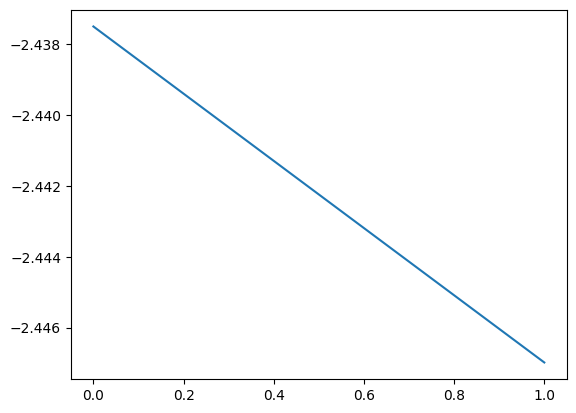

<Figure size 640x480 with 0 Axes>

In [8]:
with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'r') as hist:
    history = json.load(hist)
    
for key, values in history.items():
    plt.plot(values, label=key)
plt.show()
plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/History/{MODEL_NAME}_History.png')
plt.clf()

## Predict on Train

In [9]:
SPLIT_NAME = 'Train'

# output = denormalize(model.predict_step(train_data, start=0, steps=50, mode='sum'))
output = model.predict_step(train_data, start=25, steps=75, mode='mean')

# data_true = denormalize(train_label[0:50, :, :].numpy())
data_true = train_label[25:100, :, :].numpy()
data_predicted = output.reshape(output.shape[0], output.shape[-1])
data_true = data_true.reshape(data_true.shape[0], data_true.shape[-1])

data_true = denormalize(data_true, name='MetrLA')
data_predicted = denormalize(data_predicted, name='MetrLA')
for i in range(10):
    first_elements_arr1 = [subarr[i] for subarr in data_true]
    first_elements_arr2 = [subarr[i] for subarr in data_predicted]
    # Plotting
    plt.plot(first_elements_arr1, label='True')
    plt.plot(first_elements_arr2, label='Predicted')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(f'Line Plot of Train Feature {i}')
    plt.legend()
    plt.show()
    plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/{SPLIT_NAME}/{MODEL_NAME}_Feature_{i}.png')
    plt.clf()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:10<00:00, 93.30it/s]


## Generate on Train

In [10]:
# output = denormalize(model.generate_step(train_data, start=0, steps=200, mode='mean'))
output = model.generate_step(train_data, start=25, steps=75, mode='mean')

# data_true = denormalize(train_label[0:200, :, :].numpy())
data_true = train_label[25:100, :, :].numpy()
data_predicted = output.reshape(output.shape[0], output.shape[-1])
data_true = data_true.reshape(data_true.shape[0], data_true.shape[-1])

data_true = denormalize(data_true, name='MetrLA')
data_predicted = denormalize(data_predicted, name='MetrLA')

data_predicted
for i in range(10):
    first_elements_arr1 = [subarr[i] for subarr in data_true]
    first_elements_arr2 = [subarr[i] for subarr in data_predicted]
    # Plotting
    plt.plot(first_elements_arr1, label='True')
    plt.plot(first_elements_arr2, label='Generated')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(f'Line Plot of Train Feature {i}')
    plt.legend()
    plt.show()
    plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/{SPLIT_NAME}/{MODEL_NAME}_Feature_{i}_GEN.png')
    plt.clf()

In [13]:
# import pandas as pd
# df = pd.DataFrame(data_predicted)
# str = [773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,765604,767471,716339,773906,765273,716331,771667,716337,769953,769402,769403,769819,769405,716941,717578,716960,717804,767572,767573,773012,773013,764424,769388,716328,717819,769941,760987,718204,718045,769418,768066,772140,773927,760024,774012,774011,767609,769359,760650,716956,769831,761604,717495,716554,773953,767470,716955,764949,773954,767366,769444,773939,774067,769443,767750,767751,767610,773880,764766,717497,717490,717491,717492,717493,765176,717498,717499,765171,718064,718066,765164,769431,769430,717610,767053,767621,772596,772597,767350,767351,716571,773023,767585,773024,717483,718379,717481,717480,717486,764120,772151,718371,717489,717488,717818,718076,718072,767455,767454,761599,717099,773916,716968,769467,717576,717573,717572,717571,717570,764760,718089,769847,717608,767523,716942,718090,769867,717472,717473,759591,764781,765099,762329,716953,716951,767509,765182,769358,772513,716958,718496,769346,773904,718499,764853,761003,717502,759602,717504,763995,717508,765265,773996,773995,717469,717468,764106,717465,764794,717466,717461,717460,717463,717462,769345,716943,772669,717582,717583,717580,716949,717587,772178,717585,716939,768469,764101,767554,773975,773974,717510,717513,717825,767495,767494,717821,717823,717458,717459,769926,764858,717450,717452,717453,759772,717456,771673,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373]

In [14]:
# df.columns = str
# df.to_csv('TeachForcingMetrLAGTM.csv', index=False)

In [15]:

print(mmd_linear(data_true, data_predicted))  # 6.0
print(mmd_rbf(data_true, data_predicted))  # 0.5822
print(mmd_poly(data_true, data_predicted))  # 2436.5

13440.039
0.014333333820104599
21517238272.0
